# New Narratives for old Buildings

Finding narratives through bigram and trigram analysis

In [1]:
# import necessary libraries
import os, re, csv
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from itertools import islice
from nltk.corpus import stopwords
import spacy
import string
import pickle
import matplotlib.pyplot as plt

# 1. Loading the datasets (all languages)

Use google drive storage or local copy of data

In [6]:
#Google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
path = '/content/gdrive/MyDrive/CDA/'

In [ ]:
path = 'datasets/'

In [8]:
# Country code: change here between 'NL' and 'UK'
cc_list = ['NL', 'UK', 'DE', 'FR']

# NL

## 0.1 Loading the dataset: NL

Use google drive storage or local copy of data

In [9]:
raw_data_file = path+cc_list[0]+'_dataset_website-content-crawler.json'

In [10]:
# Import json data from Apify scraping
df=pd.read_json(raw_data_file)

# Print the DataFrame
df

,url,crawl,metadata,screenshotUrl,text,markdown,debug
0,http://weldam.nl/,{'loadedUrl': 'http://weldam.nl/english/home.h...,{'canonicalUrl': 'http://weldam.nl/english/hom...,NaN,"Introduction - Weldam\nIntroduction\nWeldam, s...",# Introduction - Weldam\n\n### Introduction\n\...,{'requestHandlerMode': 'browser'}
1,http://weldam.nl/nederlands.html,{'loadedUrl': 'http://weldam.nl/nederlands.htm...,{'canonicalUrl': 'http://weldam.nl/nederlands....,NaN,Nederlands - Weldam\nCopyright Landgoed Weldam...,# Nederlands - Weldam\n\nCopyright Landgoed We...,{'requestHandlerMode': 'browser'}
2,http://weldam.nl/nederlands/beginpagina/test-2...,{'loadedUrl': 'http://weldam.nl/nederlands/beg...,{'canonicalUrl': 'http://weldam.nl/nederlands/...,NaN,Test 1.2 - Weldam\nCopyright Landgoed Weldam 2...,# Test 1.2 - Weldam\n\nCopyright Landgoed Weld...,{'requestHandlerMode': 'browser'}
3,https://www.huisdoorn.nl/,"{'loadedUrl': 'https://www.huisdoorn.nl/', 'lo...","{'canonicalUrl': 'https://www.huisdoorn.nl/', ...",NaN,Ontdek de geschiedenis - Museum Huis Doorn\nDe...,# Ontdek de geschiedenis - Museum Huis Doorn\n...,{'requestHandlerMode': 'browser'}
4,https://www.museumdefundatie.nl/,{'loadedUrl': 'https://www.museumdefundatie.nl...,{'canonicalUrl': 'https://www.museumdefundatie...,NaN,Museum de FundatieTwitter Widget Iframe\nMuseu...,# Museum de FundatieTwitter Widget Iframe\n\n!...,{'requestHandlerMode': 'browser'}
...,...,...,...,...,...,...,...
10946,https://www.kasteelheeswijk.nl/en/my-bookings/,{'loadedUrl': 'https://www.kasteelheeswijk.nl/...,{'canonicalUrl': 'https://www.kasteelheeswijk....,NaN,Mijn boekingenreCAPTCHA\nMijn boekingen\n[book...,# Mijn boekingenreCAPTCHA\n\n## Mijn boekingen...,{'requestHandlerMode': 'browser'}
10947,https://www.kasteelheeswijk.nl/de/2023/blog/tr...,{'loadedUrl': 'https://www.kasteelheeswijk.nl/...,{'canonicalUrl': 'https://www.kasteelheeswijk....,NaN,Kasteel trouwen | Unieke trouwlocatie\nHet jaw...,# Kasteel trouwen | Unieke trouwlocatie\n\nHet...,{'requestHandlerMode': 'browser'}
10948,https://www.kasteelheeswijk.nl/en/2023/blog/tr...,{'loadedUrl': 'https://www.kasteelheeswijk.nl/...,{'canonicalUrl': 'https://www.kasteelheeswijk....,NaN,Kasteel trouwen | Unieke trouwlocatie\nHet jaw...,# Kasteel trouwen | Unieke trouwlocatie\n\nHet...,{'requestHandlerMode': 'browser'}
10949,https://www.kasteelheeswijk.nl/de/plan-je-bezo...,{'loadedUrl': 'https://www.kasteelheeswijk.nl/...,{'canonicalUrl': 'https://www.kasteelheeswijk....,NaN,Lunchen Bij de Barones | Gezellig bij Kasteel ...,# Lunchen Bij de Barones | Gezellig bij Kastee...,{'requestHandlerMode': 'browser'}


In [11]:
# correcting the data to include a missing castle (why was it missing?)
df_missing = pd.read_json(path+'/NL_LG_dataset_website-content-crawler_2025-02-06_09-40-33-880.json')
result = pd.concat([df, df_missing])

In [12]:
df = result
df.shape

(11000, 7)

###  0.1.1 Selecting data, sorting and deduplicating

In [14]:
# select only two columns for analysis: url and text
df=df[['url','text']]
df.head()

,url,text
0,http://weldam.nl/,"Introduction - Weldam\nIntroduction\nWeldam, s..."
1,http://weldam.nl/nederlands.html,Nederlands - Weldam\nCopyright Landgoed Weldam...
2,http://weldam.nl/nederlands/beginpagina/test-2...,Test 1.2 - Weldam\nCopyright Landgoed Weldam 2...
3,https://www.huisdoorn.nl/,Ontdek de geschiedenis - Museum Huis Doorn\nDe...
4,https://www.museumdefundatie.nl/,Museum de FundatieTwitter Widget Iframe\nMuseu...


Join all pages from a domain to an entry in the analysis: add a new column which will contain only the main domain name.

In [15]:
# function to extract the main domain from the url in the dataset
def extract_main_domain(url):
    if not isinstance(str(url), str):
        print('NOT VALID',url)
        return None
    match = re.findall('(?m)http(?:s?):\/\/.*?([^\.\/]+?\.[^\.]+?)(?:\/|$)', str(url)) #'www\.?([^/]+)'
    return match[0].lstrip('www.') if match else None

In [16]:
# Load the list of domains from a csv file:
cc_column = cc_list[0]+' domains'
#print(cc_column)

urls = pd.read_csv(path+'url_lists/'+cc_list[0]+'_urls.csv')[cc_column].values.tolist()

# Extract main domains from nl_urls
domains = {extract_main_domain(url) for url in urls if extract_main_domain(url) is not None}

# Check if main domains in list_of_links match any domain in nl_domains
matching_links = [link for link in df.url if extract_main_domain(link) in domains]

In [17]:
# this cell can be skipped, it is only for verification

# check how many lines in the dataframe have a matching link to the list of urls
print(len(matching_links))

10951


In [18]:
# Add a new column 'domain' and fill it by applying the extract_main_domain function to the 'url' column
df['domain'] = df['url'].apply(extract_main_domain)
df.head()

,url,text,domain
0,http://weldam.nl/,"Introduction - Weldam\nIntroduction\nWeldam, s...",eldam.nl
1,http://weldam.nl/nederlands.html,Nederlands - Weldam\nCopyright Landgoed Weldam...,eldam.nl
2,http://weldam.nl/nederlands/beginpagina/test-2...,Test 1.2 - Weldam\nCopyright Landgoed Weldam 2...,eldam.nl
3,https://www.huisdoorn.nl/,Ontdek de geschiedenis - Museum Huis Doorn\nDe...,huisdoorn.nl
4,https://www.museumdefundatie.nl/,Museum de FundatieTwitter Widget Iframe\nMuseu...,museumdefundatie.nl


In [19]:
df=df.sort_values('url', ascending=False)

In [ ]:
# Deduplicate entries
duplicate_rows = df[df.duplicated(subset=['text'], keep=False)]

# check results
#for index, row in duplicate_rows.iterrows():
#    print(f"URL: {row['url']}\nText: {row['text'][0:50]}\n")

In [21]:
df = df[~df.index.isin(duplicate_rows.index.tolist())]
df.shape

(8084, 3)

In [ ]:
# consider removing pages that contain '404' and similar messages; may remove pages with content!!!
not_found = ['Helaas, hier is iets mis gegaan', 'Pagina niet gevonden', 'Email Protection', '404']
rows_to_drop = []
find_not_found = lambda df, not_found: [index for index, row in df.iterrows() if any(item in row['text'] for item in not_found)]
rows_to_drop = find_not_found(df, not_found)

print(len(rows_to_drop), rows_to_drop)

311 [4231, 4228, 9895, 9889, 8100, 768, 772, 767, 771, 757, 759, 769, 760, 770, 8166, 8168, 8167, 8169, 1923, 5289, 5290, 10721, 5985, 9772, 5930, 5992, 9535, 9546, 5993, 5995, 4014, 5987, 9634, 5989, 3737, 9539, 9805, 9637, 6479, 2291, 6356, 10724, 10764, 10767, 10766, 10768, 10765, 10769, 9787, 9788, 9821, 9822, 9897, 5551, 5586, 6059, 5553, 6058, 6060, 5550, 5579, 7746, 10927, 10938, 9526, 3594, 9631, 9630, 9522, 3577, 9652, 9525, 9651, 9653, 9524, 3582, 2999, 9050, 9049, 3585, 9065, 8956, 3765, 3277, 9001, 2804, 9056, 3259, 3252, 3014, 3258, 3257, 3241, 4764, 4718, 980, 4663, 1017, 4691, 10683, 4703, 5699, 5614, 5659, 5667, 5662, 9521, 3540, 6056, 6057, 6772, 6816, 6778, 6792, 6931, 6814, 6913, 6738, 6739, 6740, 2476, 6777, 7239, 6987, 6986, 6985, 2547, 6838, 6837, 6836, 2510, 6020, 9127, 8291, 8289, 987, 986, 996, 984, 983, 988, 990, 989, 991, 1027, 1007, 998, 1021, 1000, 1001, 1002, 999, 1012, 1005, 1008, 1011, 1013, 1016, 1014, 1020, 1022, 1024, 1032, 1039, 1025, 1028, 1026, 107

In [ ]:
df = df[~df.index.isin(rows_to_drop)]
df.shape

(10689, 3)

### 0.1.2 Close reading one document
(we consider one website as a 'document')

In [22]:
df.domain.unique()

array(['twickel.nl', 'sypesteyn.nl', 'slotzuylen.nl', 'slotloevestein.nl',
       'schierstins.nl', 'ruinevanbrederode.nl', 'ruine-ravesteyn.nl',
       'poptaslot.nl', 'museumnienoord.nl', 'museummartena.nl',
       'museumijsselstein.nl', 'museumdefundatie.nl', 'muiderslot.nl',
       'middachten.nl', 'mensinge.nl', 'menkemaborg.nl',
       'landgoedvilsteren.nl', 'landgoedoldenhof.nl',
       'landgoedbouvigne.nl', 'landgoedboschenvaart.nl',
       'kasteelwijlre.nl', 'kasteelwarmelo.nl', 'kasteelvalkenburg.nl',
       'kasteeltuinen.nl', 'kasteeltuinassumburg.nl',
       'kasteelteylingen.nl', 'kasteelradboud.nl', 'kasteelparkborn.nl',
       'kasteelnemerlaer.nl', 'kasteelkeukenhof.nl',
       'kasteelhoensbroek.nl', 'kasteelheeze.nl', 'kasteelheeswijk.nl',
       'kasteelgroeneveld.nl', 'kasteelgeldrop.nl', 'kasteeldussen.nl',
       'kasteelduivenvoorde.nl', 'kasteeldoornenburg.nl',
       'kasteeldever.nl', 'kasteeldehaar.nl', 'kasteelboxmeer.nl',
       'kasteelamerongen.nl', 

In [ ]:
# then combine these into a list of pages
document = df[df['domain'] == 'museumdefundatie.nl']['text'].tolist()

# remove new line characters, count words&characters in each line of the text
clean_document = []
word_count = 0
character_count = 0
for i in document:
    j = i.replace('\n', ' ').replace('\r', '')
    w = len(j.split())
    word_count += w
    character_count +=len(j)
    clean_document.append(j)

In [ ]:
print('word_count:', word_count, '\ncharacter_count:', character_count)
clean_document

word_count: 145629 
character_count: 968608 
the document: ['Museum de FundatieTwitter Widget Iframe Museum de Fundatie owns and manages a vast collection of visual arts. Collection and exhibitions are on display at two locations: Kasteel Het Nijenhuis near Heino and Museum de Fundatie in Zwolle. TICKETS MUSEUM DE FUNDATIE ZWOLLE TICKETS KASTEEL HET NIJENHUIS Museum de Fundatie: Today opened from 11:00 - 17:00 Nijenhuis Castle and the Sculpture Garden:  Today opened from 11:00 - 17:00', 'Sculpture garden - Museum de FundatieTwitter Widget Iframe From: 01 january 2016 Through: 31 december 2024 Location: Kasteel Het Nijenhuis Sculpture garden - near Kasteel het Nijenhuis Please note that from November through mid-March, some of the sculptures in the Sculpture Garden are covered to protect them from the cold. PLEASE NOTE: Kasteel het Nijenhuis will only be accessible via the stationsweg from Heino station/centre Heino in the coming weeks. The castle is not accessible from the Wechterholt.

## 0.2 Counting terms NL

In [23]:
terms_list_all = ['koloni', 'slaaf', 'slaven', 'slavernij',
                  'ongelijkheid', 'democratie', 'armoede',
                  'bediende', 'arbeider']
                  #'loon', 'pacht', 'boer', 'boerd', 'indië', 'nederlands-indië', 'de oost', 'het oosten',
                  #'voc', 'verenigde oostindische compagnie', 'upstairs-downstairs',
                  #'vrouw', 'gender', 'diversiteit', 'diverse','rijk', 'arm', 'inclusie'
#term_list = ['koloni']
term_list = ['slavernij', 'slaaf', 'slaven']
#term_list = ['ongelijkheid', 'democratie', 'armoede']
#term_list = ['diversiteit', 'biodiversiteit', 'inclusiviteit']
#term_list = ['bediende','arbeider']

In [ ]:
# count terms in short lists, using term_list variable:
for term in term_list:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[term_list] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
result_df = df_filtered[['domain','url','slavernij', 'slaaf', 'slaven']]
result_df.to_csv(path+'outputs/NL_2024_all_terms.csv', index=False)
#rint(result_df.to_string())

In [ ]:
# drop columns to reset
df = df.drop(term_list, axis=1)
df.head()

,url,text,domain
10686,https://www.twickel.nl/hilligenpad,Het Hilligenpad - Stichting Twickel\nHilligenp...,twickel.nl
16,https://www.twickel.nl/,Home - Stichting Twickel\nAgenda\nLichtjeswand...,twickel.nl
20,https://www.sypesteyn.nl/,Kasteel Sypesteyn\nVanaf maandag 4 november zi...,sypesteyn.nl
10,https://www.slotzuylen.nl/,Kasteel - Slot Zuylenslotzuylen - YouTubereCAP...,slotzuylen.nl
4128,https://www.slotloevestein.nl/zakelijke-events/,Zakelijke events - Slot Loevestein\nZoek je ee...,slotloevestein.nl


In [ ]:
# count all terms:
for term in terms_list_all:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[terms_list_all] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
filter_list = ['domain','url'] + terms_list_all
result_df = df_filtered[filter_list]
result_df.to_csv(path+'outputs/NL_2024_all_terms.csv', index=False)
#print(result_df.to_string())

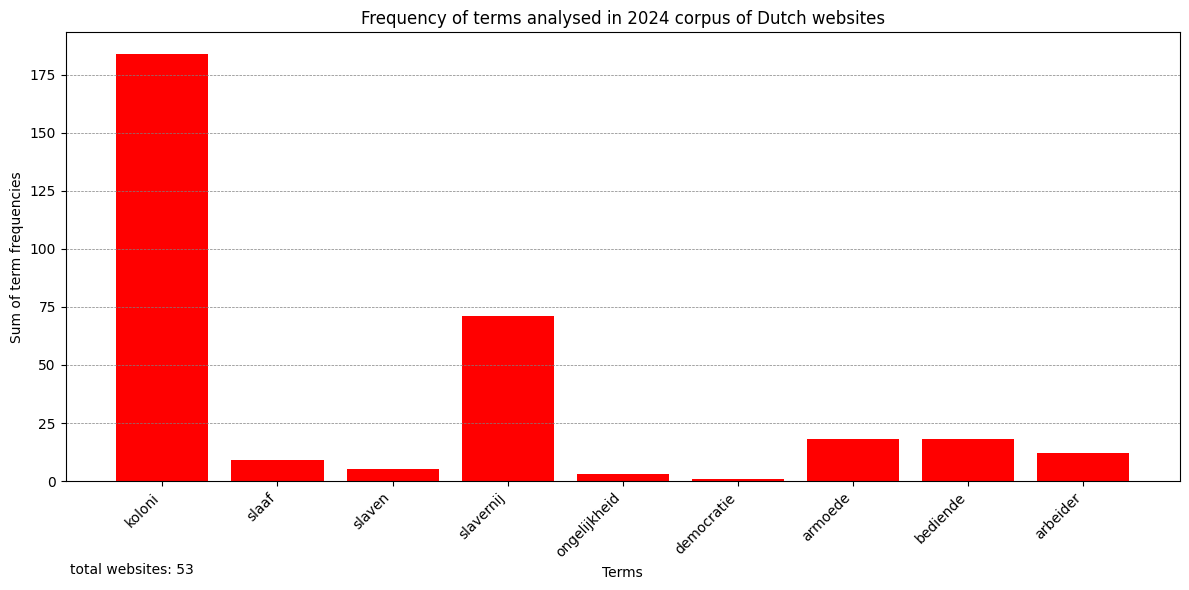

In [40]:
# Calculate the sum of values for each specified column
column_sums = result_df[terms_list_all].sum()

# Create a bar chart with pink bars
plt.figure(figsize=(12, 6))
# Add horizontal lines for values in the legend
for value in [25, 50, 75, 100, 125, 150, 175]:
  plt.axhline(y=value, color='grey', linestyle='--', linewidth=0.5)
plt.bar(column_sums.index, column_sums.values, color='red')

# Customize the plot
plt.xlabel("Terms")
plt.ylabel("Sum of term frequencies")
plt.title("Frequency of terms analysed in 2024 corpus of Dutch websites")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add two columns from the df dataframe on the left
plt.text(-0.8, -40, f"total websites: {len(df.domain.unique())}", fontsize=10, color='black')
plt.savefig(path+"outputs/NL_2024_all_terms.png", transparent=True)
plt.show()

In [41]:
df = df.drop(terms_list_all, axis=1)
df.head()

,url,text,domain
10686,https://www.twickel.nl/hilligenpad,Het Hilligenpad - Stichting Twickel\nHilligenp...,twickel.nl
16,https://www.twickel.nl/,Home - Stichting Twickel\nAgenda\nLichtjeswand...,twickel.nl
20,https://www.sypesteyn.nl/,Kasteel Sypesteyn\nVanaf maandag 4 november zi...,sypesteyn.nl
10,https://www.slotzuylen.nl/,Kasteel - Slot Zuylenslotzuylen - YouTubereCAP...,slotzuylen.nl
4128,https://www.slotloevestein.nl/zakelijke-events/,Zakelijke events - Slot Loevestein\nZoek je ee...,slotloevestein.nl


# UK

## 1.1 Loading the dataset: UK

Use google drive storage or local copy of data

In [42]:
raw_data_file = path+cc_list[1]+'_dataset_website-content-crawler.json'

In [43]:
# Import json data from Apify scraping
df=pd.read_json(raw_data_file)

# Print the DataFrame
df

,url,crawl,metadata,screenshotUrl,text,markdown,debug
0,https://www.whittingtoncastle.co.uk/visit-us,{'loadedUrl': 'https://www.whittingtoncastle.c...,{'canonicalUrl': 'https://www.whittingtoncastl...,NaN,Visit Us — Whittington Castle\nOn the Welsh bo...,# Visit Us — Whittington Castle\n\nOn the Wels...,{'requestHandlerMode': 'browser'}
1,https://www.whittingtoncastle.co.uk/kitchenthe...,{'loadedUrl': 'https://www.whittingtoncastle.c...,{'canonicalUrl': 'https://www.whittingtoncastl...,NaN,Kitchen@theCastle — Whittington Castle\nAt Whi...,# Kitchen@theCastle — Whittington Castle\n\n##...,{'requestHandlerMode': 'browser'}
2,https://www.whittingtoncastle.co.uk/home,{'loadedUrl': 'https://www.whittingtoncastle.c...,{'canonicalUrl': 'https://www.whittingtoncastl...,NaN,Whittington Castle\nA stunning 12th century ca...,# Whittington Castle\n\n![](https://images.squ...,{'requestHandlerMode': 'browser'}
3,https://www.whittingtoncastle.co.uk/weddings-w...,{'loadedUrl': 'https://www.whittingtoncastle.c...,{'canonicalUrl': 'https://www.whittingtoncastl...,NaN,Get in Touch — Whittington CastlereCAPTCHA\nWe...,# Get in Touch — Whittington CastlereCAPTCHA\n...,{'requestHandlerMode': 'browser'}
4,https://www.whittingtoncastle.co.uk/events,{'loadedUrl': 'https://www.whittingtoncastle.c...,{'canonicalUrl': 'https://www.whittingtoncastl...,NaN,Events — Whittington Castle\nUpcoming events\n...,# Events — Whittington Castle\n\nUpcoming even...,{'requestHandlerMode': 'browser'}
...,...,...,...,...,...,...,...
6937,https://www.hants.gov.uk/business/recruitment/...,{'loadedUrl': 'https://www.hants.gov.uk/busine...,{'canonicalUrl': 'https://www.hants.gov.uk/bus...,NaN,Events | Business and economy\nOur events and ...,# Events | Business and economy\n\nOur events ...,{'requestHandlerMode': 'browser'}
6938,https://www.hants.gov.uk/business/recruitment/...,{'loadedUrl': 'https://www.hants.gov.uk/busine...,{'canonicalUrl': 'https://www.hants.gov.uk/bus...,NaN,Premises | Business and economy\nThe premises ...,# Premises | Business and economy\n\nThe premi...,{'requestHandlerMode': 'browser'}
6939,https://www.hants.gov.uk/business/recruitment/...,{'loadedUrl': 'https://www.hants.gov.uk/busine...,{'canonicalUrl': 'https://www.hants.gov.uk/bus...,NaN,Reception | Business and economy\nWe have rece...,# Reception | Business and economy\n\nWe have ...,{'requestHandlerMode': 'browser'}
6940,https://www.hants.gov.uk/business/recruitment/...,{'loadedUrl': 'https://www.hants.gov.uk/busine...,{'canonicalUrl': 'https://www.hants.gov.uk/bus...,NaN,The Great Hall | Business and economy\nThe Gre...,# The Great Hall | Business and economy\n\nThe...,{'requestHandlerMode': 'browser'}


In [47]:
# find additional datasets
!ls "$path" | grep "^UK_"

UK_dataset_website-content-crawler.json
UK_EH_dataset_website-content-crawler_2025-03-18_13-49-50-417.json
UK_PC_dataset_website-content-crawler_2025-03-11_12-28-08-810.json


In [48]:
# correcting the data to include a missing castle (why was it missing?)
df_missing1 = pd.read_json(path+'/UK_EH_dataset_website-content-crawler_2025-03-18_13-49-50-417.json')
df_missing2 = pd.read_json(path+'/UK_PC_dataset_website-content-crawler_2025-03-11_12-28-08-810.json')
result = pd.concat([df, df_missing1, df_missing2])

In [49]:
df = result
df.shape

(9712, 7)

### 1.1.1 Selecting data, sorting and deduplicating

In [50]:
# select only two columns for analysis: url and text
df=df[['url','text']]
df.head()

,url,text
0,https://www.whittingtoncastle.co.uk/visit-us,Visit Us — Whittington Castle\nOn the Welsh bo...
1,https://www.whittingtoncastle.co.uk/kitchenthe...,Kitchen@theCastle — Whittington Castle\nAt Whi...
2,https://www.whittingtoncastle.co.uk/home,Whittington Castle\nA stunning 12th century ca...
3,https://www.whittingtoncastle.co.uk/weddings-w...,Get in Touch — Whittington CastlereCAPTCHA\nWe...
4,https://www.whittingtoncastle.co.uk/events,Events — Whittington Castle\nUpcoming events\n...


Join all pages from a domain to an entry in the analysis: add a new column which will contain only the main domain name.

In [51]:
# function to extract the main domain from the url in the dataset
def extract_main_domain(url):
    if not isinstance(str(url), str):
        print('NOT VALID',url)
        return None
    match = re.findall('(?m)http(?:s?):\/\/.*?([^\.\/]+?\.[^\.]+?)(?:\/|$)', str(url)) #'www\.?([^/]+)'
    return match[0].lstrip('www.') if match else None

In [52]:
# Load the list of domains from a csv file:
cc_column = cc_list[1]+' domains'
#print(cc_column)

urls = pd.read_csv(path+'url_lists/'+cc_list[1]+'_urls.csv')[cc_column].values.tolist()

# Extract main domains from nl_urls
domains = {extract_main_domain(url) for url in urls if extract_main_domain(url) is not None}

# Check if main domains in list_of_links match any domain in nl_domains
matching_links = [link for link in df.url if extract_main_domain(link) in domains]

In [ ]:
# check all urls against 2018 collection

# optional: save this list as a csv file
df.url.to_csv(path+"/output/2024_uk_urls.csv", sep=',',index=False)

In [53]:
# this cell can be skipped, it is only for verification

# check how many lines in the dataframe have a matching link to the list of urls
print(len(matching_links))

9712


In [54]:
# Add a new column 'domain' and fill it by applying the extract_main_domain function to the 'url' column
df['domain'] = df['url'].apply(extract_main_domain)
df.head()

<ipython-input-54-78111174b86d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['domain'] = df['url'].apply(extract_main_domain)


,url,text,domain
0,https://www.whittingtoncastle.co.uk/visit-us,Visit Us — Whittington Castle\nOn the Welsh bo...,co.uk
1,https://www.whittingtoncastle.co.uk/kitchenthe...,Kitchen@theCastle — Whittington Castle\nAt Whi...,co.uk
2,https://www.whittingtoncastle.co.uk/home,Whittington Castle\nA stunning 12th century ca...,co.uk
3,https://www.whittingtoncastle.co.uk/weddings-w...,Get in Touch — Whittington CastlereCAPTCHA\nWe...,co.uk
4,https://www.whittingtoncastle.co.uk/events,Events — Whittington Castle\nUpcoming events\n...,co.uk


In [55]:
df=df.sort_values('url', ascending=False)

In [ ]:
# Deduplicate entries
duplicate_rows = df[df.duplicated(subset=['text'], keep=False)]
for index, row in duplicate_rows.iterrows():
    print(f"URL: {row['url']}\nText: {row['text'][0:100]}\n")

In [58]:
df = df[~df.index.isin(duplicate_rows.index.tolist())]
df.shape

(8134, 3)

### 1.1.2 Check content

In [61]:
df.domain.unique()


array(['co.uk', 'entworthcastle.org', 'arwick-castle.com',
       'tutburycastle.com', 'tonbridgecastle.org', 'org.uk',
       'rockinghamcastle.com', 'penshurstplace.com', 'oakhamcastle.org',
       'gov.uk', 'ludlowcastle.com', 'lincolncastle.com',
       'lancastercastle.com', 'hornbycastle.com', 'hemyockcastle.uk',
       'fulhampalace.org', 'eyesuffolk.org', 'ac.uk', 'deenepark.com',
       'chillinghamcastle.com', 'burtonagnes.com', 'broughtoncastle.com',
       'berkeley-castle.com', 'bamburghcastle.com', 'athelhampton.com',
       'arundelcastle.org', 'alnwickcastle.com', 'turtontower.com',
       'leeds-castle.com', 'herstmonceux-castle.com', 'eltonhall.com',
       'cholmondeleycastle.com'], dtype=object)

In [ ]:
# extract all rows (lines) where the value of 'domain' is ...
# then combine these into a list of pages
document = df[df['domain'] == 'nationaltrust.org.uk']['text'].tolist()

# remove new line characters, count words&characters in each line of the text
clean_document = []
word_count = 0
character_count = 0
for i in document:
    j = i.replace('\n', ' ').replace('\r', '')
    w = len(j.split())
    word_count += w
    character_count +=len(j)
    clean_document.append(j)

In [ ]:
print('word_count:', word_count, '\ncharacter_count:', character_count)
clean_document

## 1.2 Counting terms UK

In [69]:
terms_list_all = ['coloni','slave','slavery',
                  'inequality','democracy','poverty',
                  'servant','worker','labourer']
term_list = ['coloni']
#term_list = ['inequality','democracy','poverty']
#term_list = ['slave','slavery']
#term_list = ['diversity', 'inclusion']
#term_list = ['servant','worker','labourer']

In [ ]:
for term in term_list:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[term_list] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
result_df = df_filtered[['domain','url','coloni']]
result_df.to_csv(path+'outputs/2024_filtered_output.csv', index=False)
#print(result_df.to_string())

In [ ]:
# drop columns to reset
df = df.drop(term_list, axis=1)
df.head()

,url,text,domain
138,https://www.woburnabbey.co.uk/,Woburn attractions | Woburn\nCustomize Consent...,oburnabbey.co.uk
3,https://www.whittingtoncastle.co.uk/weddings-w...,Get in Touch — Whittington CastlereCAPTCHA\nWe...,hittingtoncastle.co.uk
0,https://www.whittingtoncastle.co.uk/visit-us,Visit Us — Whittington Castle\nOn the Welsh bo...,hittingtoncastle.co.uk
168,https://www.whittingtoncastle.co.uk/trips-and-...,Trips and Tours — Whittington Castle\nWe at Wh...,hittingtoncastle.co.uk
166,https://www.whittingtoncastle.co.uk/support-us,Support Us — Whittington Castle\nThe Whittingt...,hittingtoncastle.co.uk


In [73]:
# count all terms:
for term in terms_list_all:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[terms_list_all] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
result_df = df_filtered[['domain','url','coloni','slave','slavery',
                  'inequality','democracy','poverty',
                  'servant','worker','labourer']]
result_df.to_csv(path+'outputs/2024_filtered_output.csv', index=False)
#print(result_df.to_string())

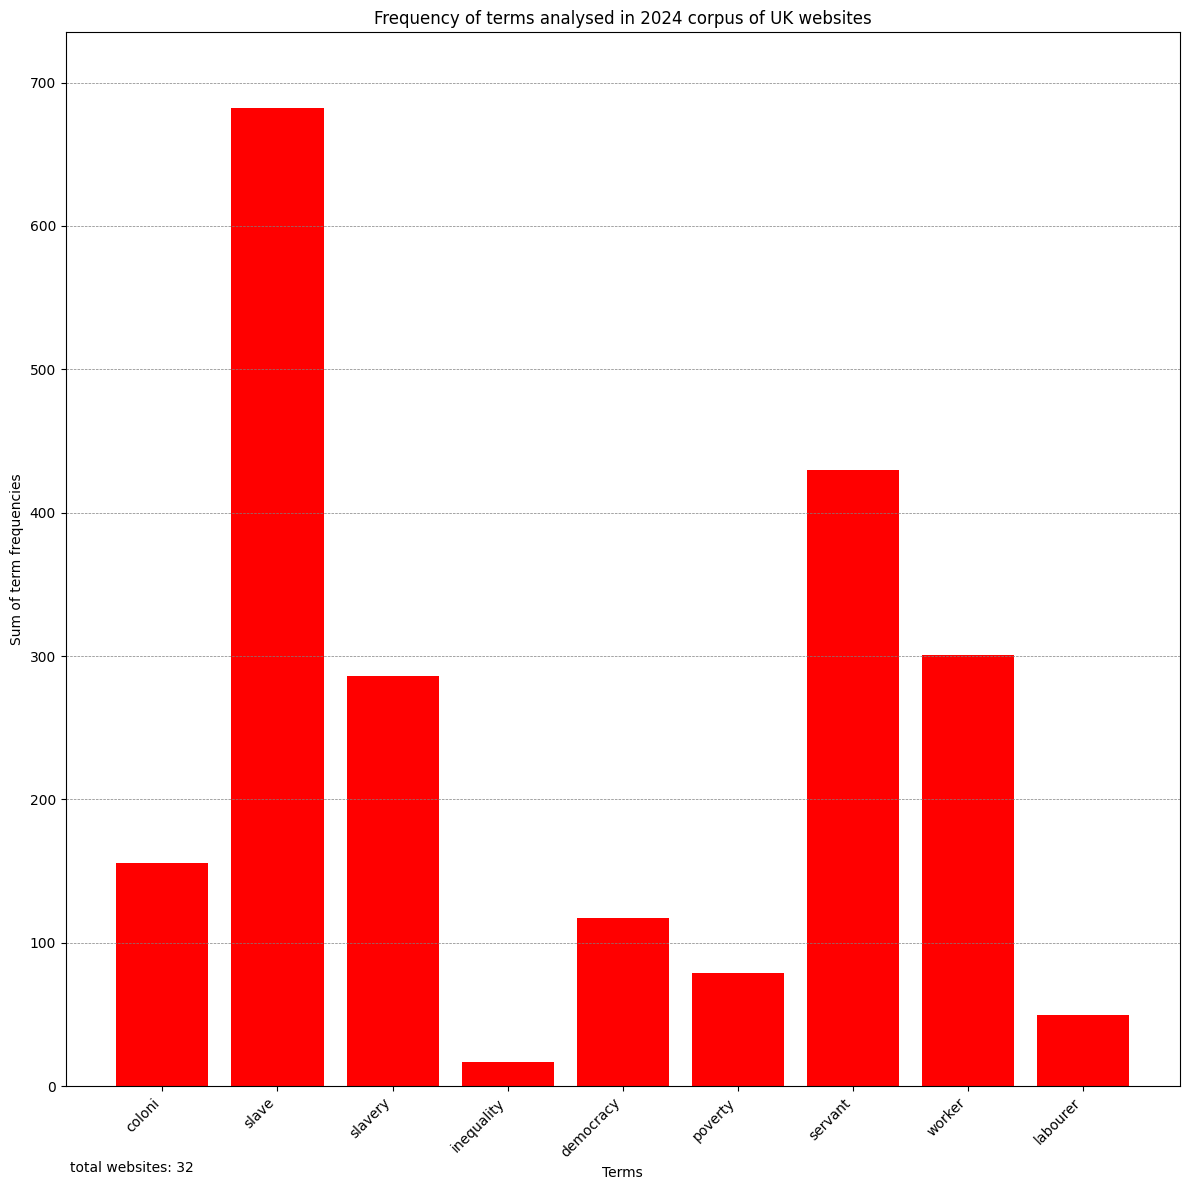

In [79]:
# Calculate the sum of values for each specified column
column_sums = result_df[terms_list_all].sum()

# Create a bar chart with pink bars
plt.figure(figsize=(12, 12))
# Add horizontal lines for values in the legend
for value in [100, 200, 300, 400, 500, 600, 700]:
  plt.axhline(y=value, color='grey', linestyle='--', linewidth=0.5)
plt.bar(column_sums.index, column_sums.values, color='red')

# Customize the plot
plt.xlabel("Terms")
plt.ylabel("Sum of term frequencies")
plt.title("Frequency of terms analysed in 2024 corpus of UK websites")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add two columns from the df dataframe on the left
plt.text(-0.8, -60, f"total websites: {len(df.domain.unique())}", fontsize=10, color='black')
plt.savefig(path+"outputs/UK_2024_all_terms.png", transparent=True)
plt.show()

In [72]:
df = df.drop(terms_list_all, axis=1)
df.head()

,url,text,domain
138,https://www.woburnabbey.co.uk/,Woburn attractions | Woburn\nCustomize Consent...,co.uk
0,https://www.whittingtoncastle.co.uk/visit-us,Visit Us — Whittington Castle\nOn the Welsh bo...,co.uk
168,https://www.whittingtoncastle.co.uk/trips-and-...,Trips and Tours — Whittington Castle\nWe at Wh...,co.uk
166,https://www.whittingtoncastle.co.uk/support-us,Support Us — Whittington Castle\nThe Whittingt...,co.uk
1,https://www.whittingtoncastle.co.uk/kitchenthe...,Kitchen@theCastle — Whittington Castle\nAt Whi...,co.uk


# DE

## 2.1 Loading the dataset: DE

Use google drive storage or local copy of data

In [80]:
raw_data_file = path+cc_list[2]+'_dataset_website-content-crawler.json'

In [81]:
# Import json data from Apify scraping
df=pd.read_json(raw_data_file)

# Print the DataFrame
df

,url,crawl,metadata,screenshotUrl,text,markdown,debug
0,http://www.schlossparkmarisfeld.de/,{'loadedUrl': 'https://www.schlossparkmarisfel...,{'canonicalUrl': 'https://www.schlossparkmaris...,NaN,Schlosspark Marisfeld - Schlosspark Marisfeld\...,# Schlosspark Marisfeld - Schlosspark Marisfel...,{'requestHandlerMode': 'browser'}
1,http://www.schlossparkmarisfeld.de/information...,{'loadedUrl': 'https://www.schlossparkmarisfel...,{'canonicalUrl': 'https://www.schlossparkmaris...,NaN,Informationen zur Geschichte des Schlossparks\...,# Informationen zur Geschichte des Schlosspark...,{'requestHandlerMode': 'browser'}
2,http://www.schlossparkmarisfeld.de/information...,{'loadedUrl': 'https://www.schlossparkmarisfel...,{'canonicalUrl': 'https://www.schlossparkmaris...,NaN,Der Schlosspark Marisfeld - Kleine Parkgeschic...,# Der Schlosspark Marisfeld - Kleine Parkgesch...,{'requestHandlerMode': 'browser'}
3,http://www.schlossparkmarisfeld.de/information...,{'loadedUrl': 'https://www.schlossparkmarisfel...,{'canonicalUrl': 'https://www.schlossparkmaris...,NaN,Der Förderverein stellt sich vor\nDer aktuelle...,# Der Förderverein stellt sich vor\n\n**Der ak...,{'requestHandlerMode': 'browser'}
4,http://www.schlossparkmarisfeld.de/information...,{'loadedUrl': 'https://www.schlossparkmarisfel...,{'canonicalUrl': 'https://www.schlossparkmaris...,NaN,Die Vereinssatzung - Schlosspark Marisfeld\nFa...,# Die Vereinssatzung - Schlosspark Marisfeld\n...,{'requestHandlerMode': 'browser'}
...,...,...,...,...,...,...,...
10434,https://www.schlosspillnitz.de/de/veranstaltun...,{'loadedUrl': 'https://www.schlosspillnitz.de/...,{'canonicalUrl': 'https://www.schlosspillnitz....,NaN,Detailseite | Schloss & Park Pillnitz\nDas Glä...,# Detailseite | Schloss & Park Pillnitz\n\n## ...,{'requestHandlerMode': 'browser'}
10435,https://www.schlosspillnitz.de/de/veranstaltun...,{'loadedUrl': 'https://www.schlosspillnitz.de/...,{'canonicalUrl': 'https://www.schlosspillnitz....,NaN,Detailseite | Schloss & Park Pillnitz\nDas Glä...,# Detailseite | Schloss & Park Pillnitz\n\n## ...,{'requestHandlerMode': 'browser'}
10436,https://www.schlosspillnitz.de/de/veranstaltun...,{'loadedUrl': 'https://www.schlosspillnitz.de/...,{'canonicalUrl': 'https://www.schlosspillnitz....,NaN,Detailseite | Schloss & Park Pillnitz\nSondera...,# Detailseite | Schloss & Park Pillnitz\n\n## ...,{'requestHandlerMode': 'browser'}
10437,https://www.schlosspillnitz.de/de/veranstaltun...,{'loadedUrl': 'https://www.schlosspillnitz.de/...,{'canonicalUrl': 'https://www.schlosspillnitz....,NaN,Detailseite | Schloss & Park Pillnitz\nSondera...,# Detailseite | Schloss & Park Pillnitz\n\n## ...,{'requestHandlerMode': 'browser'}


### 2.1.1 Selecting data, sorting and deduplicating

In [82]:
# select only two columns for analysis: url and text
df=df[['url','text']]
df.head()

,url,text
0,http://www.schlossparkmarisfeld.de/,Schlosspark Marisfeld - Schlosspark Marisfeld\...
1,http://www.schlossparkmarisfeld.de/information...,Informationen zur Geschichte des Schlossparks\...
2,http://www.schlossparkmarisfeld.de/information...,Der Schlosspark Marisfeld - Kleine Parkgeschic...
3,http://www.schlossparkmarisfeld.de/information...,Der Förderverein stellt sich vor\nDer aktuelle...
4,http://www.schlossparkmarisfeld.de/information...,Die Vereinssatzung - Schlosspark Marisfeld\nFa...


Join all pages from a domain to an entry in the analysis: add a new column which will contain only the main domain name.

In [83]:
# function to extract the main domain from the url in the dataset
def extract_main_domain(url):
    if not isinstance(str(url), str):
        print('NOT VALID',url)
        return None
    match = re.findall('(?m)http(?:s?):\/\/.*?([^\.\/]+?\.[^\.]+?)(?:\/|$)', str(url)) #'www\.?([^/]+)'
    return match[0].lstrip('www.') if match else None

In [84]:
# Load the list of domains from a csv file:
cc_column = cc_list[2]+' domains'
#print(cc_column)

urls = pd.read_csv(path+'url_lists/'+cc_list[2]+'_urls.csv')[cc_column].values.tolist()

# Extract main domains from nl_urls
domains = {extract_main_domain(url) for url in urls if extract_main_domain(url) is not None}

# Check if main domains in list_of_links match any domain in nl_domains
matching_links = [link for link in df.url if extract_main_domain(link) in domains]

In [85]:
# this cell can be skipped, it is only for verification

# check how many lines in the dataframe have a matching link to the list of urls
print(len(matching_links))

10198


In [86]:
# Add a new column 'domain' and fill it by applying the extract_main_domain function to the 'url' column
df['domain'] = df['url'].apply(extract_main_domain)
df.head()

<ipython-input-86-78111174b86d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['domain'] = df['url'].apply(extract_main_domain)


,url,text,domain
0,http://www.schlossparkmarisfeld.de/,Schlosspark Marisfeld - Schlosspark Marisfeld\...,schlossparkmarisfeld.de
1,http://www.schlossparkmarisfeld.de/information...,Informationen zur Geschichte des Schlossparks\...,schlossparkmarisfeld.de
2,http://www.schlossparkmarisfeld.de/information...,Der Schlosspark Marisfeld - Kleine Parkgeschic...,schlossparkmarisfeld.de
3,http://www.schlossparkmarisfeld.de/information...,Der Förderverein stellt sich vor\nDer aktuelle...,schlossparkmarisfeld.de
4,http://www.schlossparkmarisfeld.de/information...,Die Vereinssatzung - Schlosspark Marisfeld\nFa...,schlossparkmarisfeld.de


In [87]:
df=df.sort_values('url', ascending=False)

In [89]:
# Deduplicate entries
duplicate_rows = df[df.duplicated(subset=['text'], keep=False)]
#for index, row in duplicate_rows.iterrows():
#    print(f"URL: {row['url']}\nText: {row['text'][0:100]}\n")

In [90]:
len(duplicate_rows.index.tolist())

5332

In [91]:
df = df[~df.index.isin(duplicate_rows.index.tolist())]
df.shape

(5107, 3)

### 2.1.2 Check content

In [92]:
df.domain.unique()


array(['asserburg-anholt.de', 'artburg.de', 'stiftungfriedenstein.de',
       'stiftung-friedenstein.de', 'schlossveldenz.com',
       'schlosspillnitz.de', 'schlossparkmarisfeld.de',
       'schloss-weikersheim.de', 'schloss-rochsburg.de',
       'schloss-neuenbuerg.de', 'schloss-moritzburg.de',
       'schloss-mespelbrunn.de', 'schloss-klippenstein.de',
       'schloss-hundisburg.de', 'schloss-heidelberg.de',
       'schloss-gluecksburg.de', 'schloss-eutin.de', 'schloss-burgk.de',
       'schloss-ahrensburg.de', 'schloesser-hessen.de',
       'rettung-schloss-blankenburg.de', 'neuschwanstein.de',
       'mv-schloesser.de', 'museumwilhelmsburg.de',
       'museumsverbund-nordfriesland.de', 'museumserver.de',
       'museum-schloss-fellenberg.de', 'museum-ranis.de', 'moyland.de',
       'ludwiggalerie.de', 'lindaschwarz.com', 'leuchtenburg.de',
       'landesmuseum.de', 'landesmuseum-stuttgart.de',
       'kunstsammlungen-coburg.de', 'heimatverein-schnaittach.com',
       'der-dresdner

In [ ]:
# extract all rows (lines) where the value of 'domain' is ...
# then combine these into a list of pages
document = df[df['domain'] == 'museumsverbund-nordfriesland.de']['text'].tolist()

# remove new line characters, count words&characters in each line of the text
clean_document = []
word_count = 0
character_count = 0
for i in document:
    j = i.replace('\n', ' ').replace('\r', '')
    w = len(j.split())
    word_count += w
    character_count +=len(j)
    clean_document.append(j)

In [ ]:
print('word_count:', word_count, '\ncharacter_count:', character_count)
clean_document

## 2.2 Counting terms DE

In [103]:
terms_list_all = ['koloni','sklave','sklaverei',
                  'ungleichheit','demokratie','armut',
                  'diener','arbeiter']
#term_list = ['koloni']
#term_list = ['ungleichheit','demokratie','armut']
#term_list = ['sklave','sklaverei']
#term_list = ['diversität','inklusion]
term_list = ['diener','arbeiter']

In [ ]:
for term in term_list:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[term_list] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
result_df = df_filtered[['domain','url','diener','arbeiter']]
result_df.to_csv(path+'outputs/2024_filtered_output.csv', index=False)
#print(result_df.to_string())

In [ ]:
# drop columns to reset
df = df.drop(term_list, axis=1)
df.head()

,url,text,domain
4990,https://www.wasserburg-anholt.de/index.php/de/...,Wasserburg Anholt\nVeranstaltungen\nGeführte P...,asserburg-anholt.de
4974,https://www.wasserburg-anholt.de/index.php/de/...,Öffnungszeiten & Preise\nHaus\n*1-stündige Füh...,asserburg-anholt.de
4982,https://www.wasserburg-anholt.de/index.php/de/...,"Museum Wasserburg Anholt - Kontakt, Anfahrt un...",asserburg-anholt.de
984,https://www.wasserburg-anholt.de/index.php/de/,Wasserburg Anholt\nVerehrte Besucher!\nWährend...,asserburg-anholt.de
2439,https://www.wartburg.de/workshop/wartburggesch...,Wartburggeschichte(n)\nWartburg KOMPAKT I für ...,artburg.de


In [105]:
# count all terms:
for term in terms_list_all:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[terms_list_all] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
filter_list = ['domain','url'] + terms_list_all
result_df = df_filtered[filter_list]
result_df.to_csv(path+'outputs/DE_2024_all_terms.csv', index=False)
#print(result_df.to_string())

Visualize the results

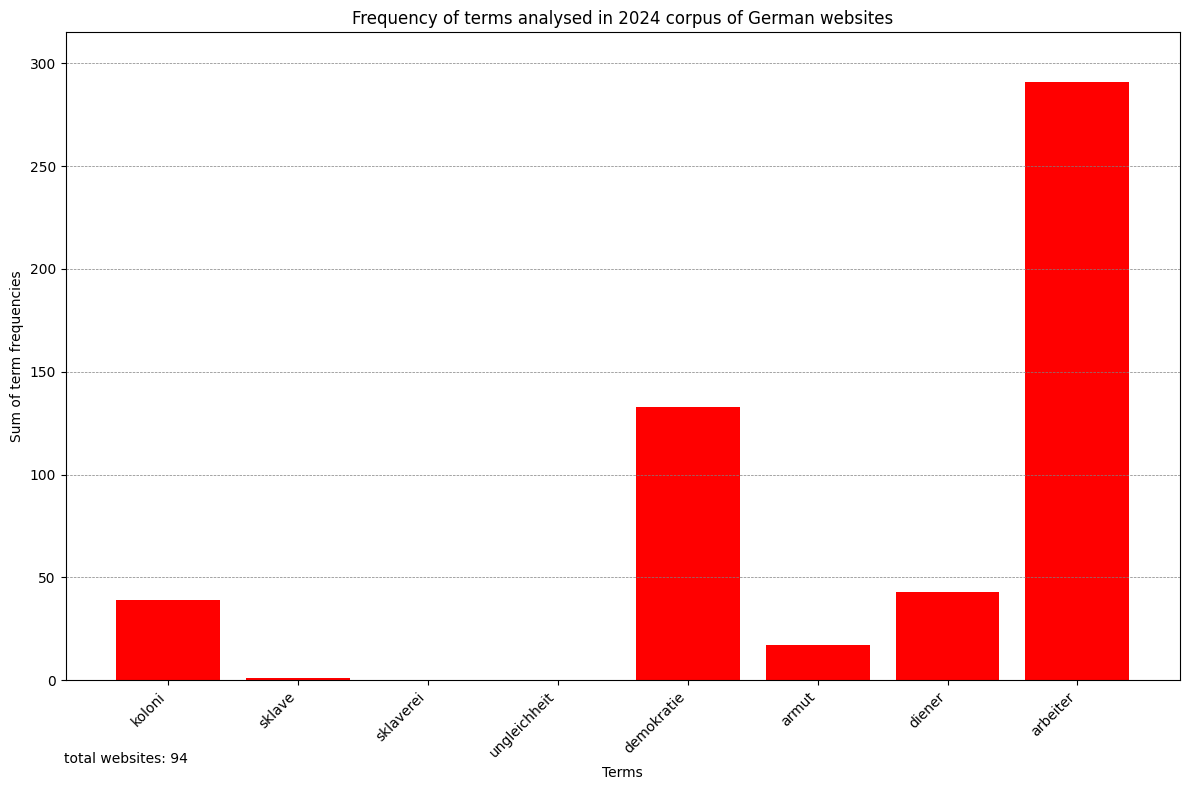

In [106]:
# Calculate the sum of values for each specified column
column_sums = result_df[terms_list_all].sum()

# Create a bar chart with pink bars
plt.figure(figsize=(12, 8))
# Add horizontal lines for values in the legend
for value in [50, 100, 150, 200, 250, 300]:
  plt.axhline(y=value, color='grey', linestyle='--', linewidth=0.5)
plt.bar(column_sums.index, column_sums.values, color='red')

# Customize the plot
plt.xlabel("Terms")
plt.ylabel("Sum of term frequencies")
plt.title("Frequency of terms analysed in 2024 corpus of German websites")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add two columns from the df dataframe on the left
plt.text(-0.8, -40, f"total websites: {len(df.domain.unique())}", fontsize=10, color='black')
plt.savefig(path+"outputs/DE_2024_all_terms.png", transparent=True)
plt.show()

In [ ]:
df = df.drop(terms_list_all, axis=1)
df.head()

# FR

## 3.1 Loading the dataset: FR


Use google drive storage or local copy of data

In [109]:
raw_data_file = path+cc_list[3]+'_dataset_website-content-crawler.json'

In [110]:
# Import json data from Apify scraping
df=pd.read_json(raw_data_file)

# Print the DataFrame
df

,url,crawl,metadata,screenshotUrl,text,markdown,debug
0,https://www.chateau-combourg.com/privatisation,{'loadedUrl': 'https://www.chateau-combourg.co...,{'canonicalUrl': 'https://www.chateau-combourg...,NaN,Events — COMBOURG\nLe château et le parc peuve...,# Events — COMBOURG\n\nLe château et le parc p...,{'requestHandlerMode': 'browser'}
1,https://www.chateau-combourg.com/chateaubriand,{'loadedUrl': 'https://www.chateau-combourg.co...,{'canonicalUrl': 'https://www.chateau-combourg...,NaN,Chateaubriand — COMBOURG\nFrançois-René de Cha...,# Chateaubriand — COMBOURG\n\n![1200px-Anne-Lo...,{'requestHandlerMode': 'browser'}
2,https://www.chateau-combourg.com/prixlitteraire,{'loadedUrl': 'https://www.chateau-combourg.co...,{'canonicalUrl': 'https://www.chateau-combourg...,NaN,Prix Littéraire — COMBOURG\nLe Prix Combourg-C...,# Prix Littéraire — COMBOURG\n\n**Le Prix Comb...,{'requestHandlerMode': 'browser'}
3,https://www.chateau-combourg.com/contact,{'loadedUrl': 'https://www.chateau-combourg.co...,{'canonicalUrl': 'https://www.chateau-combourg...,NaN,Contact — COMBOURG\nNom(obligatoire)\nPrénom\n...,# Contact — COMBOURG\n\nNom(obligatoire)\n\nPr...,{'requestHandlerMode': 'browser'}
4,https://www.suscinio.fr/,"{'loadedUrl': 'https://www.suscinio.fr/', 'loa...","{'canonicalUrl': 'https://www.suscinio.fr/', '...",NaN,Château de Suscinio dans le Morbihan\nOuvert t...,# Château de Suscinio dans le Morbihan\n\n* ...,{'requestHandlerMode': 'browser'}
...,...,...,...,...,...,...,...
22537,https://chateau-etelan.fr/articles/Du%20jazz%2...,{'loadedUrl': 'https://chateau-etelan.fr/artic...,{'canonicalUrl': 'https://chateau-etelan.fr/ar...,NaN,Page non trouvée | Château d'Ételan\nLe châtea...,# Page non trouvée | Château d'Ételan\n\n![](h...,{'requestHandlerMode': 'browser'}
22538,https://chateau-etelan.fr/agenda/page/5/,{'loadedUrl': 'https://chateau-etelan.fr/agend...,{'canonicalUrl': 'https://chateau-etelan.fr/ag...,NaN,Évènements depuis 13/10/2019 – 21/09/2019 | Pa...,# Évènements depuis 13/10/2019 – 21/09/2019 | ...,{'requestHandlerMode': 'http'}
22539,https://chateau-etelan.fr/agenda/swingin-blue-...,{'loadedUrl': 'https://chateau-etelan.fr/agend...,{'canonicalUrl': 'https://chateau-etelan.fr/ag...,NaN,Swing'in blue avec J.B. Leroy\nEn octobre 2013...,# Swing'in blue avec J.B. Leroy\n\nEn octobre ...,{'requestHandlerMode': 'http'}
22540,https://chateau-etelan.fr/agenda/melancolie-po...,{'loadedUrl': 'https://chateau-etelan.fr/agend...,{'canonicalUrl': 'https://chateau-etelan.fr/ag...,NaN,Mélancolie pour rire | Château d'Ételan\nMathi...,# Mélancolie pour rire | Château d'Ételan\n\n*...,{'requestHandlerMode': 'http'}


### 2.1.1 Selecting data, sorting and deduplicating

In [111]:
# select only two columns for analysis: url and text
df=df[['url','text']]
df.head()

,url,text
0,https://www.chateau-combourg.com/privatisation,Events — COMBOURG\nLe château et le parc peuve...
1,https://www.chateau-combourg.com/chateaubriand,Chateaubriand — COMBOURG\nFrançois-René de Cha...
2,https://www.chateau-combourg.com/prixlitteraire,Prix Littéraire — COMBOURG\nLe Prix Combourg-C...
3,https://www.chateau-combourg.com/contact,Contact — COMBOURG\nNom(obligatoire)\nPrénom\n...
4,https://www.suscinio.fr/,Château de Suscinio dans le Morbihan\nOuvert t...


Join all pages from a domain to an entry in the analysis: add a new column which will contain only the main domain name.

In [112]:
# function to extract the main domain from the url in the dataset
def extract_main_domain(url):
    if not isinstance(str(url), str):
        print('NOT VALID',url)
        return None
    match = re.findall('(?m)http(?:s?):\/\/.*?([^\.\/]+?\.[^\.]+?)(?:\/|$)', str(url)) #'www\.?([^/]+)'
    return match[0].lstrip('www.') if match else None

In [113]:
# Load the list of domains from a csv file:
cc_column = cc_list[3]+' domains'
#print(cc_column)

urls = pd.read_csv(path+'url_lists/'+cc_list[3]+'_urls.csv')[cc_column].values.tolist()

# Extract main domains from nl_urls
domains = {extract_main_domain(url) for url in urls if extract_main_domain(url) is not None}

# Check if main domains in list_of_links match any domain in nl_domains
matching_links = [link for link in df.url if extract_main_domain(link) in domains]

In [114]:
# this cell can be skipped, it is only for verification

# check how many lines in the dataframe have a matching link to the list of urls
print(len(matching_links))

22435


In [ ]:
# Add a new column 'domain' and fill it by applying the extract_main_domain function to the 'url' column
df['domain'] = df['url'].apply(extract_main_domain)
df.head()

In [116]:
df=df.sort_values('url', ascending=False)

In [ ]:
# Deduplicate entries
duplicate_rows = df[df.duplicated(subset=['text'], keep=False)]

#check the results
#for index, row in duplicate_rows.iterrows():
#    print(f"URL: {row['url']}\nText: {row['text'][0:100]}\n")

In [ ]:
len(duplicate_rows.index.tolist())

13764

In [118]:
df = df[~df.index.isin(duplicate_rows.index.tolist())]
df.shape

(8778, 3)

### 2.1.2 Check content

In [119]:
df.domain.unique()


array(['yonne.fr', 'suscinio.fr', 'parcfloraldelasource.com',
       'palaisdecompiegne.fr', 'museudiacorsica.corsica',
       'musee-rochechouart.com', 'murolchateau.com',
       'ledonjondehoudan.fr', 'larochecourbon.fr', 'lamotteglain.com',
       'haut-koenigsbourg.fr', 'harcourt-normandie.fr', 'gombervaux.fr',
       'fortqueyras.fr', 'forteresse-mornas.fr',
       'folleville-chateau-medieval.fr', 'fleckenstein.fr',
       'domainedecourances.com', 'domainedechantilly.com',
       'citadelledesisteron.fr', 'chenonceau.com', 'chateaux-ladrome.fr',
       'chateauvillandry.fr', 'chateaugratot.com', 'chateaugavray.fr',
       'chateaudutaureau.bzh', 'chateaudurivau.com', 'chateaudorcher.com',
       'chateaudetanlay.fr', 'chateaudesully.com',
       'chateaudesaintesuzanne.fr', 'chateaudemargon.com',
       'chateaudelourmarin.com', 'chateaudelarocheguyon.fr',
       'chateaudekeriolet.com', 'chateaudejosselin.com',
       'chateaudeguise.fr', 'chateaudegoulaine.fr',
       'chateau

In [ ]:
# extract all rows (lines) where the value of 'domain' is ...
# then combine these into a list of pages
document = df[df['domain'] == 'chateau-bazoches.com']['text'].tolist()

# remove new line characters, count words&characters in each line of the text
clean_document = []
word_count = 0
character_count = 0
for i in document:
    j = i.replace('\n', ' ').replace('\r', '')
    w = len(j.split())
    word_count += w
    character_count +=len(j)
    clean_document.append(j)

In [ ]:
print('word_count:', word_count, '\ncharacter_count:', character_count)
clean_document

## 2.2 Counting terms FR

In [120]:
terms_list_all = ['coloni','esclave','esclavage',
                  'inégalité','démocratie','pauvreté',
                  'serviteur','travailleur','ouvrier']
#term_list = ['coloni']
term_list = ['inégalité','démocratie','pauvreté']
#term_list = ['esclave','esclavage']
#term_list = ['diversité','inclusion']
#term_list = ['serviteur','ouvrier']

In [ ]:
for term in term_list:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[term_list] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
result_df = df_filtered[['domain','url','serviteur','ouvrier']]
result_df.to_csv(path+'outputs/2024_filtered_output.csv', index=False)
print(result_df.to_string())

In [ ]:
# drop columns to reset
df = df.drop(term_list, axis=1)
df.head()

,url,text,domain
1776,https://www.yonne.fr/toutes-les-actualites/,Actualités - Yonne le département\nPublié le 9...,yonne.fr
1782,https://www.yonne.fr/tous-les-evenements/,Evénements - Yonne le département\nMon départe...,yonne.fr
1778,https://www.yonne.fr/salle-de-presse/,Salle de presse - Yonne le département\nSalle ...,yonne.fr
254,https://www.yonne.fr/mon-quotidien/yonne-sport...,Sport : Yonne Sport Seniors\nAfin d’inciter le...,yonne.fr
255,https://www.yonne.fr/mon-quotidien/yonne-sport...,Sport : Yonne Sport Adapté\nLe Département de ...,yonne.fr


In [121]:
# count all terms:
for term in terms_list_all:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[terms_list_all] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
filter_list = ['domain','url'] + terms_list_all
result_df = df_filtered[filter_list]
result_df.to_csv(path+'outputs/FR_2024_all_terms.csv', index=False)
#print(result_df.to_string())

Visualize the results

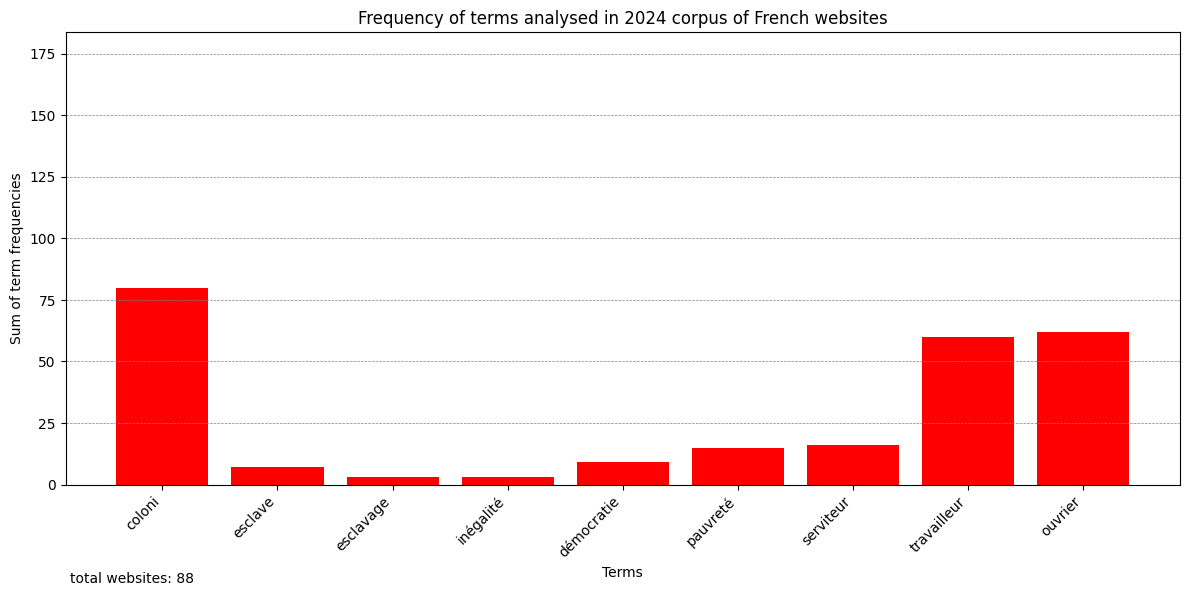

In [125]:
# Calculate the sum of values for each specified column
column_sums = result_df[terms_list_all].sum()

# Create a bar chart with pink bars
plt.figure(figsize=(12, 6))
# Add horizontal lines for values in the legend
for value in [25, 50, 75, 100, 125, 150, 175]:
  plt.axhline(y=value, color='grey', linestyle='--', linewidth=0.5)
plt.bar(column_sums.index, column_sums.values, color='red')

# Customize the plot
plt.xlabel("Terms")
plt.ylabel("Sum of term frequencies")
plt.title("Frequency of terms analysed in 2024 corpus of French websites")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add two columns from the df dataframe on the left
plt.text(-0.8, -40, f"total websites: {len(df.domain.unique())}", fontsize=10, color='black')
plt.savefig(path+"outputs/FR_2024_all_terms.png", transparent=True)
plt.show()

In [ ]:
df = df.drop(terms_list_all, axis=1)
df.head()

# 3. Collocations

In [126]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [130]:
%%capture
# change 'UK' here for country code by hand
!wget 'https://raw.githubusercontent.com/jazoza/cultural-data-analysis/refs/heads/main/stopwords_archive/NL.txt'
!wget 'https://raw.githubusercontent.com/jazoza/cultural-data-analysis/refs/heads/main/stopwords_archive/UK.txt'
!wget 'https://raw.githubusercontent.com/jazoza/cultural-data-analysis/refs/heads/main/stopwords_archive/DE.txt'
!wget 'https://raw.githubusercontent.com/jazoza/cultural-data-analysis/refs/heads/main/stopwords_archive/FR.txt'

In [136]:
%%capture
#!python -m spacy download nl_core_news_sm
#!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
#!python -m spacy download fr_core_news_sm

In [137]:
#load spacy
nl_nlp = spacy.load('nl_core_news_sm')
uk_nlp = spacy.load('en_core_web_sm')
de_nlp = spacy.load('de_core_news_sm')
fr_nlp = spacy.load('fr_core_news_sm')

In [138]:
#check which corpus is loaded as df:
df.head()

,url,text,domain,coloni,esclave,esclavage,inégalité,démocratie,pauvreté,serviteur,travailleur,ouvrier
1776,https://www.yonne.fr/toutes-les-actualites/,Actualités - Yonne le département\nPublié le 9...,yonne.fr,0,0,0,0,0,0,0,0,0
1782,https://www.yonne.fr/tous-les-evenements/,Evénements - Yonne le département\nMon départe...,yonne.fr,0,0,0,0,0,0,0,0,0
1778,https://www.yonne.fr/salle-de-presse/,Salle de presse - Yonne le département\nSalle ...,yonne.fr,0,0,0,0,0,0,0,0,0
254,https://www.yonne.fr/mon-quotidien/yonne-sport...,Sport : Yonne Sport Seniors\nAfin d’inciter le...,yonne.fr,0,0,0,0,0,0,0,0,0
255,https://www.yonne.fr/mon-quotidien/yonne-sport...,Sport : Yonne Sport Adapté\nLe Département de ...,yonne.fr,0,0,0,0,0,0,0,0,0


In [141]:
# load a list of 'stopwords' in the language you are analyzing
def get_stopwords_list(stop_file_path):
    """load stop words """
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return list(frozenset(stop_set))
stopwords_path = cc_list[3]+".txt" # change the value 0(NL)-1(UK)-2(DE)-3(FR) depending on the CC (country code)
stopwords = get_stopwords_list(stopwords_path)
special_stop_words = ['nbsp', ' ', '', '—', '\’s']
stopwords_ext = stopwords+special_stop_words

In [143]:
#function to remove non-ascii characters
def _removeNonAscii(s): return "".join(i for i in s if ord(i)<128)

In [144]:
#function to clean and lemmatize comments
def clean_documents(text):
    #remove punctuations
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    nopunct = regex.sub(" ", str(text))
    #use spacy to lemmatize comments
    doc = fr_nlp(nopunct, disable=['parser','ner'])
    lemma = [token.lemma_ for token in doc]
    return lemma
#apply function to clean and lemmatize comments
lemmatized = df.text.map(clean_documents)
#make sure to lowercase everything
lemmatized = lemmatized.map(lambda x: [word.lower() for word in x])
lemmatized.head()
unlist_documents = [item for items in lemmatized for item in items]

In [145]:
unlist_documents = [item for items in lemmatized for item in items if item not in stopwords_ext ]
# check restuls
#unlist_documents

In [146]:
# initiate bigrams and trigrams
bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()

In [147]:
# identify all collocations in the flat list of words from all documents
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(unlist_documents)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(unlist_documents)

Calculate basic frequency

In [148]:
bigram_freq = bigramFinder.ngram_fd.items()

In [149]:
bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)

In [150]:
bigramFreqTable.head().reset_index(drop=True)

,bigram,freq
0,"(�, �)",65253
1,"(of, the)",5882
2,"( , www)",3222
3,"(in, the)",2455
4,"(4e16, a5e0)",2174


In [152]:
# compute basic trigrams frequency
trigram_freq = trigramFinder.ngram_fd.items()
trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['trigram','freq']).sort_values(by='freq', ascending=False)
trigramFreqTable[:10]

,trigram,freq
636987,"(�, �, �)",36178
235932,"(a183, 4e16, a5e0)",2174
235933,"(4e16, a5e0, 4040d79f84eb)",2174
235931,"(deeca512, a183, 4e16)",2174
200014,"( , www, koenigsbourg)",1743
200015,"(www, koenigsbourg, fr)",1743
37,"(https, , www)",1649
67259,"(http, , www)",1485
235944,"( , ecommunityimage, deeca512)",1087
235930,"(ecommunityimager, deeca512, a183)",1087


Find meaningful bi- and tri-grams by filtering adjectives and nouns based on an nltk functionality

In [153]:
#function to filter for ADJ/NN bigrams
def rightTypes(ngram):
    for word in ngram:
        if word in stopwords_ext:
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

In [154]:
#filter bigrams
filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]

In [155]:
filtered_bi[:10]

,bigram,freq
158390,"(�, �)",65253
38,"( , www)",3222
169577,"(deeca512, a183)",2174
37,"(https, )",2025
144888,"(koenigsbourg, fr)",1750
144887,"(www, koenigsbourg)",1743
7130,"( , château)",1711
30305,"(http, )",1586
168404,"(image, src)",1245
266156,"(�, s)",1174


In [156]:
# filter bigrams using chi-square
bigramChiTable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.chi_sq)), columns=['bigram','chi-sq']).sort_values(by='chi-sq', ascending=False)
bigramChiTable.head()

,bigram,chi-sq
0,"(rdfs, seealso)",2093018.0
3118,"(preservato, ospiter)",2093018.0
3098,"(pourcet, sahune)",2093018.0
3097,"(pouf, cordiforme)",2093018.0
3096,"(poudingue, pourpré)",2093018.0


In [157]:
# find meaningful trigrams by filtering basic frequency table
# function to filter trigrams
def rightTypesTri(ngram):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or '  ' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in stopwords_ext:
            return False
    first_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    third_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in first_type and tags[2][1] in third_type:
        return True
    else:
        return False

In [158]:
filtered_tri = trigramFreqTable[trigramFreqTable.trigram.map(lambda x: rightTypesTri(x))]
filtered_tri[:10]

,trigram,freq
636987,"(�, �, �)",36178
200015,"(www, koenigsbourg, fr)",1743
235930,"(ecommunityimager, deeca512, a183)",1087
235928,"(koenigsbourg, fr, ecommunityimager)",1087
235945,"(ecommunityimage, deeca512, a183)",1087
235941,"(jpg, image, src)",1085
233855,"(jpg, alt, )",1080
637424,"(�, o, �)",835
637091,"(�, w, �)",816
637020,"(�, u, �)",811


In [159]:
# Chi-sqare frequency calculation for trigrams
trigramChiTable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.chi_sq)), columns=['trigram','chi-sq']).sort_values(by='chi-sq', ascending=False)
trigramChiTable.head(20)

,trigram,chi-sq
0,"(, ܸ, ́n1o˂)",4.380724e+12
441,"(pingouin, alca, impennis)",4.380724e+12
443,"(plouaret, plougrescant, trébeurden)",4.380724e+12
444,"(plougrescant, trébeurden, trégastel)",4.380724e+12
445,"(poeta, encontrarán, serenidad)",4.380724e+12
446,"(polaco, húngaro, rumano)",4.380724e+12
447,"(polnisch, ungarisch, rumänisch)",4.380724e+12
448,"(ponderer, gravius, librans)",4.380724e+12
449,"(ponderibu, urgebantur, restabat)",4.380724e+12
450,"(porghje, spazii, critichi)",4.380724e+12


### 4.1. Explore bigrams and trigrams for specific terms:
- Dutch nobility: 'jonkheer', 'jonkvrouw', 'ridder', 'baron', 'barones', 'burggraaf', 'burggravin', 'graaf', 'gravin', 'hertog', 'hertogin', 'prins', 'prinses'

- French nobility:  'page', 'chevalier', 'ec', 'dame', 'damoiselle', 'baron', 'baronne', 'compte', 'comptesse', 'vidame', 'vicomte', 'duc', 'duchesse', 'archiduc', 'archiduchesse', 'marquis', 'marquise', 'prince', 'princesse', 'roi', 'reine', 'impérateur', 'impératrice'



In [171]:
dutch_nobility_titles = ['jonkheer', 'jonkvrouw', 'ridder', 'baron', 'barones', 'burggraaf', 'burggravin',
                         'graaf', 'gravin', 'hertog', 'hertogin', 'prins', 'prinses']
uk_nobility_titles = []
german_nobility_titles = []
french_nobility_titles = ['page', 'chevalier', 'écuyer', 'dame', 'damoiselle', 'baron', 'baronne', 'compte',
                          'comptesse', 'vidame', 'vicomte', 'duc', 'duchesse', 'archiduc', 'archiduchesse',
                          'marquis', 'marquise', 'prince', 'princesse', 'roi', 'reine', 'impérateur', 'impératrice']

In [ ]:
# find all bigrams for the term 'vrouw'
baron_bigrams = filtered_bi[filtered_bi['bigram'].astype(str).str.contains('vrouw')]
baron_bigrams[:20]
result_df.to_csv(path+'outputs/FR_2024_bigrams_'+keyword'.csv', index=False)

,bigram,freq
13726,"(man, vrouw)",26
19261,"(jong, vrouw)",24
165994,"(ridder, jonkvrouwen)",23
68511,"(vrouwe, bertha)",21
50361,"(vrouwelijk, kunstenaar)",21
165995,"(jonkvrouwen, wandel)",18
158548,"(tuinclub, vrouw)",17
13720,"(gastheer, vrouw)",16
118646,"(sterk, vrouw)",16
19372,"(vrouw, )",16


In [168]:
# find all bigrams for the keyword, save first 50 to csv file
keyword = 'homme'
keyword_filtered_bi = filtered_bi[filtered_bi['bigram'].astype(str).str.contains(keyword)]
keyword_bigramChiTable = bigramChiTable[bigramChiTable['bigram'].astype(str).str.contains(keyword)]
joined_df = pd.concat([keyword_filtered_bi, keyword_bigramChiTable], axis=1)
joined_df[:50].to_csv(path+'outputs/FR_2024_bigrams_'+keyword+'.csv', index=False)

In [170]:
# find all trigrams for the keyword
keyword = 'femme'
keyword_filtered_tri = filtered_tri[filtered_tri['trigram'].astype(str).str.contains(keyword)]
keyword_trigramChiTable = trigramChiTable[trigramChiTable['trigram'].astype(str).str.contains(keyword)]
joined_df = pd.concat([keyword_filtered_tri, keyword_trigramChiTable], axis=1)
joined_df[:50].to_csv(path+'outputs/FR_2024_trigrams_'+keyword+'.csv', index=False)

In [174]:
# prompt: for nobility title in list of nobility_titles, get the first 20 collocations (TOP 20 in filtered_bi) and arrange them in a new dataframe where each column is made of collocations of one nobility title; if there are less than 20 collocations for a nobility title, fill the column with NaN

# Create an empty DataFrame to store the results
collocation_df = pd.DataFrame()

# Iterate through the list of nobility titles
for title in nobility_titles:
  # Filter the filtered_bi DataFrame for bigrams containing the current title
  title_bigrams = filtered_bi[filtered_bi['bigram'].astype(str).str.contains(title)]

  # Get the first 20 collocations for the current title
  top_20_collocations = title_bigrams['bigram'].tolist()[:20]

  # Fill the column with NaN if there are less than 20 collocations
  if len(top_20_collocations) < 20:
    top_20_collocations += [np.nan] * (20 - len(top_20_collocations))

  # Add the collocations as a new column to the DataFrame
  collocation_df[title] = top_20_collocations

# Print the resulting DataFrame
collocation_df.to_csv(path+'outputs/FR_2024_nobility_bigrams.csv', index=False)
collocation_df


,page,chevalier,écuyer,dame,damoiselle,baron,baronne,compte,comptesse,vidame,...,archiduc,archiduchesse,marquis,marquise,prince,princesse,roi,reine,impérateur,impératrice
0,"(page, )","(chevalier, chevaleresse)","(écuyer, page)","(dame, blanche)","(gourmand, damoiselle)","(baron, beynac)","(“, baronne)","(compte, tenir)",NaN,NaN,...,"(archiduchesse, précédent)","(archiduchesse, précédent)","(marquis, lafayette)","(marquise, ange)","(princesse, chevalier)","(princesse, chevalier)","(droit, d’)","(reine, france)",NaN,"(l’, impératrice)"
1,"( , page)","(chevalier, )","(atour, écuyer)","(légende, dame)","(damoiselle, camille)","(sénéchal, baron)","(baronne, ”)","(prendre, compte)",NaN,NaN,...,"(chambre, archiduchesse)","(chambre, archiduchesse)","(marquis, castellane)","(marquise, sévigné)","(prince, impérial)","(princesse, zénaïde)","(roi, france)","(reine, elizabeth)",NaN,"(impératrice, eugénie)"
2,"(pagetype, visite)","(miguel, chevalier)","(écuyer, double)","(dame, château)",NaN,"(baron, fleckenstein)","(baronne, galeazzini)","(rendre, compte)",NaN,NaN,...,NaN,NaN,"(marquis, marquis)","(chez, marquise)","(prince, jérôme)","(prince, princesse)","(droit, entrée)","(roi, reine)",NaN,"(impératrice, loger)"
3,"( , pagetype)","(vie, chevalier)","(famille, écuyer)","(mystère, dame)",NaN,"(dernier, baron)","(cardi, baronne)","(«, compte)",NaN,NaN,...,NaN,NaN,"(marquis, marc)","(marquise, )","(double, prince)","(chevalier, princesse)","(roi, rené)","(reine, catherine)",NaN,"(impératrice, château)"
4,"(page, rechercher)","(princesse, chevalier)","(écuyer, arborer)","(chapelle, dame)",NaN,"(die, barone)","(débuter, baronne)","(compte, …)",NaN,NaN,...,NaN,NaN,"(marquis, rothelin)","(angélique, marquise)","(princesse, zénaïde)","(princesse, sicile)","( , droit)","(reine, d’)",NaN,"(impératrice, présenter)"
5,"(page, dédier)","(combat, chevalier)","(pouvoir, écuyer)","(dame, paris)",NaN,"(baron, pierrebourg)","(baronne, vie)","(compte, rendre)",NaN,NaN,...,NaN,NaN,"(marquise, ange)","(marquisette, mimi)","(prince, noir)","(famille, princesse)","(donne, droit)","(reine, )",NaN,"(impératrice, accueillir)"
6,"(bas, page)","( , chevalier)","(huit, écuyer)","(dame, d’)",NaN,"(baron, »)",NaN,"(compte, annuel)",NaN,NaN,...,NaN,NaN,"(marquise, sévigné)","(déguster, marquisette)","(prince, jean)","(jeune, princesse)","(droit, l’)","(reine, victoria)",NaN,"(impératrice, invité)"
7,"(koenigsbourg, page)","(chevalier, d’)","(écuyer, recevoir)","(madame, monsieur)",NaN,"(délivre, baron)",NaN,"(activité, compte)",NaN,NaN,...,NaN,NaN,"(marquis, sévigné)","(goûter, marquisette)","(prince, galles)","(princesse, )","(gratuité, droit)","(reine, marie)",NaN,"(impératrice, initier)"
8,"(page, site)","(quotidien, chevalier)","(louvel, écuyer)","(château, dame)",NaN,"(baron, normand)",NaN,"(compter, date)",NaN,NaN,...,NaN,NaN,"(marquis, mac)","(tester, marquisette)","(prince, princesse)","(princesse, …)","(d’, droit)","(reine, mèr)",NaN,NaN
9,"(page, isbn)","(chevalier, art)","(écuyer, fief)","(dame, roche)",NaN,"(barone, honore)",NaN,"(pouvoir, compter)",NaN,NaN,...,NaN,NaN,"(collection, marquis)","(marquisette, s)","( , prince)","(dire, princesse)","(roi, d’)","(reine, navarre)",NaN,NaN


In [184]:
# prompt: take the collocation "chevalier princesse" and search for it in every df.text cell; if it appears, output the row 'url' and 'website' as a df

# Assuming your DataFrame is named 'df' and has 'url', 'website', and 'text' columns.
# Also, assuming you have the collocation 'chevalier princesse'

# Create an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['url', 'website'])

# Iterate through the rows of the DataFrame
for index, row in df.iterrows():
  # Check if the collocation is present in the 'text' cell
  if 'courageu' in str(row['text']):
    # If it is, append the 'url' and 'website' to the result DataFrame
    result_df = pd.concat([result_df, pd.DataFrame({'website': [row['domain']], 'url': [row['url']]})], ignore_index=True)

# Print the result DataFrame
result_df


,url,website
0,https://www.chateaux-ladrome.fr/fr/toute-la-sa...,chateaux-ladrome.fr
1,https://www.chateaugavray.fr/fr-gb.php,chateaugavray.fr
2,https://www.chateaudesully.com/single-post/201...,chateaudesully.com
3,https://www.chateaudesully.com/single-post/201...,chateaudesully.com
4,https://www.chateaudelarocheguyon.fr/le-donjon/,chateaudelarocheguyon.fr
5,https://www.chateaudallegre.com/pages/evenemen...,chateaudallegre.com
6,https://www.chateaudallegre.com/pages/content/...,chateaudallegre.com
7,https://www.chateaudallegre.com/pages/content/...,chateaudallegre.com
8,https://www.chateau-pierrefonds.fr/enseignants...,chateau-pierrefonds.fr
9,https://www.chateau-if.fr/es/descubra/les-flor...,chateau-if.fr


## Word2Vec model

In [175]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# if necessary,
!pip install gensim

In [176]:
import gensim
from nltk.tokenize import word_tokenize

# X is a list of tokenized texts (i.e. list of lists of tokens)
X = [word_tokenize(item) for item in df.text.tolist()]
#print(X[0:3])
model = gensim.models.Word2Vec(X, min_count=6, vector_size=200) # min_count: how many times a word appears in the corpus; size: number of dimensions

In [ ]:
model.wv.most_similar(positive=["vrouw"], topn=20)

[('vader', 0.8318734169006348),
 ('zoon', 0.829622209072113),
 ('schilder', 0.8231922388076782),
 ('portretten', 0.8184574246406555),
 ('Godard', 0.8074954748153687),
 ('dochter', 0.7987229824066162),
 ('broer', 0.7829622030258179),
 ('dood', 0.7781422734260559),
 ('keizer', 0.7735303044319153),
 ('koningin', 0.7694973349571228),
 ('beroemde', 0.7617202997207642),
 ('Steengracht', 0.7580192685127258),
 ('graaf', 0.7541016936302185),
 ('kasteelheer', 0.7540947794914246),
 ('beeldhouwer', 0.7534154057502747),
 ('dichter', 0.7502295970916748),
 ('moeder', 0.7478094100952148),
 ('overlijden', 0.7424219846725464),
 ('koning', 0.7423788905143738),
 ('Nederlanden', 0.7399473190307617)]

In [ ]:
model.wv.most_similar(positive=["barones"], topn=20)

[('baron', 0.9017342925071716),
 ('heren', 0.8596174120903015),
 ('Oranje', 0.8521174788475037),
 ('bezittingen', 0.8302841782569885),
 ('Gelre', 0.8255923390388489),
 ('graven', 0.8142397999763489),
 ('hertogen', 0.8132580518722534),
 ('Duitse', 0.8132495284080505),
 ('dichter', 0.8131224513053894),
 ('Franse', 0.8088952898979187),
 ('hertog', 0.8071687817573547),
 ('grens', 0.8051489591598511),
 ('1707', 0.804075300693512),
 ('voormalige', 0.8035416007041931),
 ('aanleg', 0.8017495274543762),
 ('koning', 0.7966423034667969),
 ('boerderijen', 0.7959726452827454),
 ('Hélène', 0.7959276437759399),
 ('Hollandse', 0.7952153086662292),
 ('keizer', 0.7947273254394531)]

In [ ]:
model.wv.most_similar(positive=["baron"], topn=20)

[('barones', 0.9017342925071716),
 ('Oranje', 0.8849129676818848),
 ('Duitse', 0.8716451525688171),
 ('Franse', 0.8695423603057861),
 ('koning', 0.8660514950752258),
 ('graaf', 0.8573681116104126),
 ('hertog', 0.8513169288635254),
 ('Graaf', 0.8397710919380188),
 ('Hollandse', 0.8323706984519958),
 ('keizer', 0.8289907574653625),
 ('Gelre', 0.8271480798721313),
 ('toenmalige', 0.8212326765060425),
 ('Lodewijk', 0.8158407807350159),
 ('Reede', 0.8151018023490906),
 ('jonkheer', 0.8140764832496643),
 ('heer', 0.8140608072280884),
 ('André', 0.8128880262374878),
 ('Margaretha', 0.8109948039054871),
 ('beroemde', 0.8101122379302979),
 ('Engelse', 0.806041955947876)]

## Topic Modeling

Extract topics using LDA

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare the text
# Remove stop words, special characters

tf_idf = TfidfVectorizer(stop_words=stopwords_ext, min_df=8, max_df=0.9)
doc_term_matrix = tf_idf.fit_transform(df['text'])
doc_term_matrix.shape

(8084, 13206)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Apply LDA
LDA = LatentDirichletAllocation(n_components=4, random_state=12342) # 4 topics
doc_topic_matrix = LDA.fit_transform(doc_term_matrix)

In [ ]:
doc_topic_matrix.shape

(8084, 8)

In [ ]:
for topic, words in enumerate(LDA.components_):
  word_total = words.sum()  # total words weight for topic
  sorted_words = words.argsort()[::-1] # sort in descending order
  print(f'\nTopic {topic + 1:02d}') # print the topic
  for i in range(0, 10): # proint topic's top 10 words
    word = tf_idf.get_feature_names_out()[sorted_words[i]]
    word_weight = words[sorted_words[i]]
    print(f'{word} ({word_weight:.3f})')


Topic 01
navigatie (5.382)
ommen (4.778)
verhalenketel (4.640)
weergaven (4.089)
duna (3.878)
sauna (3.544)
eymerick (3.292)
jjjj (2.942)
ei (2.713)
dd (2.646)

Topic 02
the (130.213)
fundatie (112.682)
und (105.656)
collection (87.788)
read (78.735)
more (73.913)
sie (72.790)
cm (68.458)
museum (54.821)
collectie (48.278)

Topic 03
heerlen (177.615)
site (168.933)
bezoek (123.686)
goud (115.810)
historisch (106.550)
hoensbroek (101.550)
kasteel (65.777)
streekarchief (59.965)
romeins (59.792)
thermenmuseum (59.790)

Topic 04
bouvigne (15.018)
schierstins (14.078)
elk (5.828)
kastelen (5.563)
wijlre (5.085)
geladen (4.848)
geuren (4.508)
toon (4.425)
bouwstijl (4.413)
centrum (4.226)

Topic 05
the (152.980)
and (80.401)
to (64.226)
castle (50.992)
you (47.075)
doorn (44.112)
for (39.180)
can (26.325)
with (26.314)
at (24.109)

Topic 06
fogelsangh (67.899)
state (54.045)
copyright (33.054)
creative (32.221)
2015 (30.293)
ontwikkeld (30.268)
work (30.150)
cookies (28.596)
privacy (17.25

In [ ]:
perplexity = []
topic_nums = range(3, 10)
for topics in topic_nums:
  lda_a = LatentDirichletAllocation(n_components=topics, random_state=12342)
  lda_a.fit(doc_term_matrix)
  perplexity.append(lda_a.perplexity(doc_term_matrix))

In [ ]:
import seaborn as sns
ax = sns.lineplot(x=topic_nums, y=perplexity, marker = 'o')
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Perplexity')